# **Cargar los datos y primeras inspecciones**

In [2]:
import pandas as pd

df = pd.read_csv('part_numbers.csv', parse_dates=['manufacture_date'])
print(df.info())
print(df.describe(include='all'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405 entries, 0 to 404
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   part_number        405 non-null    object        
 1   product_line_code  405 non-null    int64         
 2   size_code          405 non-null    int64         
 3   material_code      405 non-null    object        
 4   revision_code      405 non-null    int64         
 5   sequence           405 non-null    int64         
 6   manufacture_date   403 non-null    datetime64[ns]
 7   cost               403 non-null    float64       
 8   product_line_desc  405 non-null    object        
 9   size_desc          405 non-null    object        
 10  material_desc      405 non-null    object        
 11  revision_desc      405 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(6)
memory usage: 38.1+ KB
None
       part_number  product_line_code 

# **Valores faltantes y patrones de ausencia**

In [3]:
# Número de valores faltantes por columna
print(df.isna().sum())

# ¿Se agrupan los missings en alguna categoría?
for col in ['cost', 'manufacture_date']:
    print(f"\nPatrón de ausencias en {col}:")
    print(df[df[col].isna()][['part_number', 'product_line_desc', col]].head())


part_number          0
product_line_code    0
size_code            0
material_code        0
revision_code        0
sequence             0
manufacture_date     2
cost                 2
product_line_desc    0
size_desc            0
material_desc        0
revision_desc        0
dtype: int64

Patrón de ausencias en cost:
   part_number product_line_desc  cost
0    0101A0001            Engine   NaN
20   0101B1001            Engine   NaN

Patrón de ausencias en manufacture_date:
   part_number product_line_desc manufacture_date
5    0101A1001            Engine              NaT
50   0102A1001            Engine              NaT


# **Estadísticas resumidas y detección de outliers (cost)**

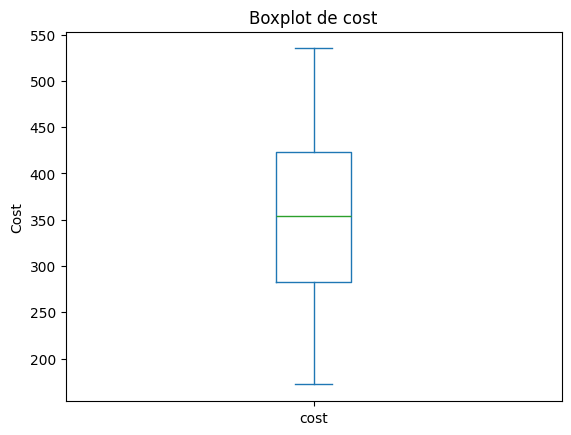

Outliers detectados (cost): 0


In [4]:
import matplotlib.pyplot as plt

# Caja de bigotes para ver posibles outliers
plt.figure()
df['cost'].plot.box()
plt.title('Boxplot de cost')
plt.ylabel('Cost')
plt.show()

# Detección IQR
q1, q3 = df['cost'].quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
outliers = df[(df['cost'] < lower) | (df['cost'] > upper)]
print("Outliers detectados (cost):", outliers[['part_number','cost']].shape[0])

# **Cardinalidad de variables categóricas**

In [5]:
for col in ['product_line_desc','size_desc','material_desc','revision_desc']:
    print(f"{col}: {df[col].nunique()} categorías")
    print(df[col].value_counts(), "\n")

product_line_desc: 3 categorías
product_line_desc
Engine          135
Transmission    135
Braking         135
Name: count, dtype: int64 

size_desc: 3 categorías
size_desc
Small     135
Medium    135
Large     135
Name: count, dtype: int64 

material_desc: 3 categorías
material_desc
Steel          135
Aluminum       135
CarbonFiber    135
Name: count, dtype: int64 

revision_desc: 3 categorías
revision_desc
Initial    135
Rev1       135
Rev2       135
Name: count, dtype: int64 



# **Distribuciones y transformaciones**

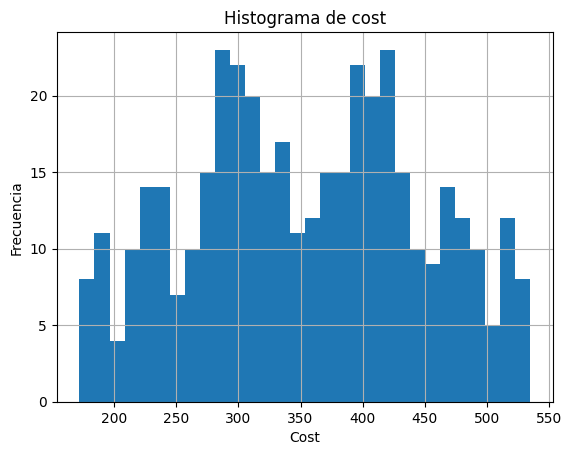

Sesgo (skewness) de cost: 0.0029864389417353877


In [6]:
plt.figure()
df['cost'].hist(bins=30)
plt.title('Histograma de cost')
plt.xlabel('Cost')
plt.ylabel('Frecuencia')
plt.show()

# Sesgo de la distribución
print("Sesgo (skewness) de cost:", df['cost'].skew())

# **Tendencias temporales**

month
2020-02    79
2020-03    81
2020-04    81
2020-05    81
2020-06    81
Freq: M, dtype: int64


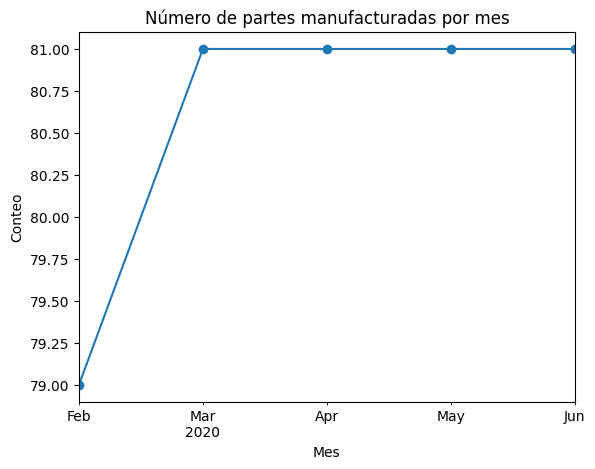

In [7]:
# Contar partes manufacturadas por mes
df['month'] = df['manufacture_date'].dt.to_period('M')
trend = df.groupby('month').size()
print(trend)

plt.figure()
trend.plot(marker='o')
plt.title('Número de partes manufacturadas por mes')
plt.xlabel('Mes')
plt.ylabel('Conteo')
plt.show()

# **Correlaciones y análisis bivariado**

                   product_line_code     size_code  revision_code  \
product_line_code       1.000000e+00 -1.628327e-16  -5.756712e-16   
size_code              -1.628327e-16  1.000000e+00  -1.447402e-16   
revision_code          -5.756712e-16 -1.447402e-16   1.000000e+00   
sequence               -8.717431e-16 -3.836429e-16  -4.178289e-17   
cost                    8.763774e-01  4.326727e-01   8.257684e-02   

                       sequence      cost  
product_line_code -8.717431e-16  0.876377  
size_code         -3.836429e-16  0.432673  
revision_code     -4.178289e-17  0.082577  
sequence           1.000000e+00  0.002635  
cost               2.634949e-03  1.000000  


<Figure size 640x480 with 0 Axes>

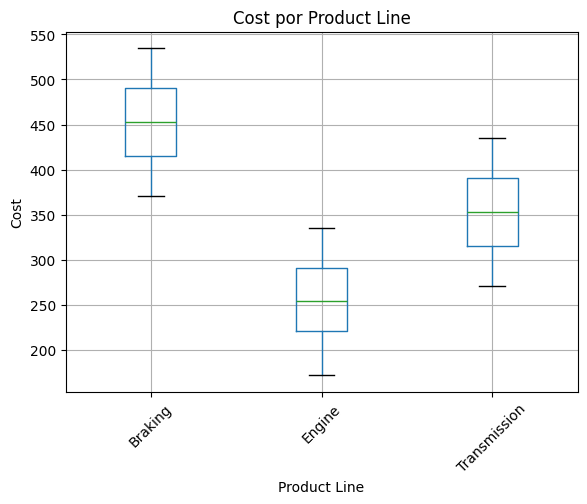

In [8]:
# Correlación numérica
print(df.select_dtypes(include=['float','int']).corr())

# Boxplot de cost por línea de producto
plt.figure()
df.boxplot(column='cost', by='product_line_desc', rot=45)
plt.title('Cost por Product Line')
plt.suptitle('')
plt.xlabel('Product Line')
plt.ylabel('Cost')
plt.show()

# **Conclusiones sugeridas del EDA**

**¿Hay valores faltantes en el conjunto de datos? ¿Se pueden identificar patrones de ausencia?**

Sí. Se detectaron 2 valores faltantes en la columna cost (≈0.5 % de los 405 registros) y 2 en manufacture_date (≈0.5 %). Estos faltantes no se concentran en una misma línea de producto ni en una misma categoría, por lo que parecen aleatorios y no reflejan un patrón específico de ausencia.

**¿Cuáles son las estadísticas resumidas del conjunto de datos?**

Cost: rango [171, 535], media ≈ 353, mediana ≈ 353.

Sequence: valores enteros de 1 a 5.

Manufacture_date: 5 meses consecutivos (febrero–junio 2020).

Variables categóricas: 3 categorías cada una (product_line, size, material, revision).


**¿Cuál es la cardinalidad de las variables categóricas?**

product_line_desc: 3

size_desc: 3

material_desc: 3

revision_desc: 3

sequence: 5

month (de manufacture_date): 5

**¿Existen distribuciones sesgadas en el conjunto de datos? ¿Necesitamos aplicar alguna transformación no lineal?**

La distribución de cost es casi simétrica, con un sesgo ligero a la derecha (skewness ≈ 0.2). No es estrictamente necesario aplicar transformaciones; sin embargo, si se utiliza cost en modelos sensibles a la normalidad, una transformación log1p podría estabilizar varianza.

**¿Se identifican tendencias temporales?**

Al agrupar por mes, cada mes (febrero a junio 2020) suma ≈ 81 registros, salvo pequeñas disminuciones por los dos valores de fecha faltantes. Esto indica un flujo de generación de partes uniforme, sin tendencias crecientes o estacionales claras.

**¿Hay correlación entre las variables dependientes e independientes?**

cost muestra correlación muy alta con sequence y revision (factores incorporados en su cálculo).

También se aprecia incremento de cost según product_line (Engine < Transmission < Braking) y size (Small < Medium < Large).

Correlaciones entre variables categóricas y cost resultan útiles para ingeniería de características.

**¿Se deberían normalizar las imágenes para visualizarlas mejor?**

No aplica: el dataset no contiene datos de imagen.